In [1]:
import nltk
import pandas as pd
import numpy as np
import re
import string
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]

In [2]:
top_articles = pd.read_json('top_articles.json')
top_articles.head()

,date,tags,title,author,claps,length,url,corpus
331,2017-02-10,"[beauty, diy, wellness, cosmetics, skincare]",Argan oil: the ingredient with a thousand virtues,Laura Morin,880,3,https://medium.com/@lauramorin_91755/argan-oil...,"No need to introduce the argan oil. Nowadays, ..."
929,2017-04-20,"[beauty, diy, wellness, cosmetics, hair]",How to use spirulina on your hair?,Laura Morin,854,3,https://medium.com/@lauramorin_91755/how-to-us...,Here is an article about the multiple benefits...
1430,2017-06-13,"[creativity, pyschology, wellness, sleep, ligh...",How to Use the Psychology of Light and Lightin...,"Donald M. Rattner, Architect",1050,8,https://medium.com/s/how-to-design-creative-wo...,"In part one of this series, I described how re..."
1660,2017-06-30,"[beauty, diy, wellness, cosmetics, skincare]",DIY ingredients: the ones to be wary of,Laura Morin,845,2,https://medium.com/@lauramorin_91755/diy-ingre...,DIY ingredients delight those looking for natu...
2003,2017-07-06,"[mental-health, startup, hr, wellness, entrepr...",It’s 2017 and Mental Health is still an issue ...,Olark,3168,4,https://medium.com/@Olark/its-2017-and-mental-...,Last week a personal email I wrote was retweet...


In [3]:
def clean(text):
    text = text.lower()
    text = re.sub('\n','',text) 
    text = re.sub('[.*?\â£]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

top_articles['clean_corpus'] = top_articles['corpus'].apply(clean)
top_articles['clean_corpus'].iloc[0]

#clean_corpus = [clean(corpus)]
#clean_corpus

'no need to introduce the argan oil nowadays this ingredient is used in countless cosmetic products and its virtues have been recognized for centuries however how do we know which argan oil to choose and how do we use itargan oil its life its storythe argan oil comes from the argan a tree that grows mainly in morocco but also in some places in algeria this oil has been used by many generations of moroccan women to take care of their skin but also… to cook note that there are two kinds of argan oil and they are very differentargan oil how to choosefirst note that the argan oil is a fairly expensive ingredient it takes  of fruit to produce  of oil and the price of  is around  unfortunately we can find a lot of counterfeiting to be sure of getting real argan oil it is necessary that the description “ natural” be affixed on the packaging so you can be sure that you do not buy another disguised product be aware also that the oil must be clear and its smell must not be stubborn if so then th

In [4]:
def counter_df(clean_corpus):
    cv = CountVectorizer(ngram_range = (1,1), stop_words='english')
    data_cv = cv.fit_transform(clean_corpus)
    return pd.DataFrame(data={'word':cv.get_feature_names(), 'count':data_cv.toarray().sum(axis=0)})

data_df = counter_df(list(top_articles['clean_corpus']))
data_df.head()

#print(cv.get_feature_names())

,word,count
0,aa,9
1,aaa,1
2,abandon,4
3,abandoned,4
4,abandoning,1


In [5]:
# Correlating text to colors that affect mood
color_db = {
    'purple_neg': ['mystery', 'mysterious', 'moodiness', 'moody', 'boredom', 'bored', 'bore', 'confusion', 'confuse', 'confused', 'disconnection', 'disconnect'],
    'purple_pos': ['connection', 'connect', 'wisdom', 'wise', 'spirituality', 'spiritual', 'royalty', 'royal, ''nobility', 'noble', 'luxury', 'luxurious', 'ambition', 'ambitious', 'wealth', 'wealthy', 'awaken', 'awake'],
    'blue_neg': ['coldness', 'cold', 'masculinity', 'masculine', 'male', 'disgust', 'disgusted', 'conflict', 'conflicting', 'aggression', 'aggressive'],
    'blue_pos': ['intuition', 'imagination', 'imagine', 'tranquility', 'tranquil', 'security', 'secure', 'integrity', 'peace', 'peaceful', 'loyalty', 'loyal', 'faith', 'faithful', 'intelligence', 'intelligent'],
    'teal_neg': ['femininity', 'feminine', 'female', 'hostility', 'hostile'],
    'teal_pos': ['communication', 'communicate', 'expression', 'express', 'healing', 'heal', 'protection', 'protect', 'sophisticated', 'cleanse', 'cleansing'],
    'green_neg': ['envy', 'envious', 'jealousy', 'jealous', 'guilt', 'guilty', 'fear', 'fearful', 'scared', 'judgmental', 'judge', 'judging', 'unforgiving', 'anxiety', 'anxious'],
    'green_pos': ['compassion', 'trust', 'freshness', 'fresh', 'environment', 'new', 'money', 'fertile', 'health', 'healthy', 'grounded', 'reconnecting', 'balanced', 'balance', 'balancing'],
    'yellow_neg': ['irresponsible', 'instability', 'grief', 'grieve', 'grieving', 'grieves', 'addiction', 'addict', 'addicted', 'insecurity', 'insecure', 'depression', 'depressed'],
    'yellow_pos': ['confident', 'confidence', 'bright', 'sunny', 'energetic', 'warm', 'happy', 'happiness', 'perky', 'joy', 'joyful', 'intellect', 'intellectual'],
    'orange_neg': ['ignorance', 'ignorant', 'sluggishness', 'sluggish', 'shame', 'ashamed', 'shameful', 'compulsiveness', 'compulsive', 'loneliness', 'lonely', 'alone', 'dependence', 'dependent'],
    'orange_pos': ['courage', 'friendliness', 'friendly', 'success', 'successful', 'creativity', 'creative', 'openness', 'open', 'sexual', 'sexy', 'sex'],
    'red_neg': ['anger', 'angry', 'unsafe', 'warned', 'warn', 'warning', 'worry', 'worried', 'volatile', 'hopelessness', 'hopeless'],
    'red_pos': ['love', 'loving', 'passion', 'passionate', 'energy', 'energetic', 'power', 'powerful', 'strength', 'strong', 'heat', 'hot', 'desire', 'safe', 'safety', 'instinctive', 'instinct', 'security', 'secure', 'liberating', 'liberate']
}
def find_color(word):
    for key in color_db.keys():
        if word in color_db[key]:
            return key
    return ''
            
data_df['color'] = data_df['word'].apply(find_color)
data_df = data_df.loc[data_df['color'] != ''].copy()
data_count = data_df.groupby('color').sum()
data_count

,count
color,
blue_neg,90
blue_pos,169
green_neg,401
green_pos,1742
orange_neg,82
orange_pos,351
purple_neg,79
purple_pos,190
red_neg,151


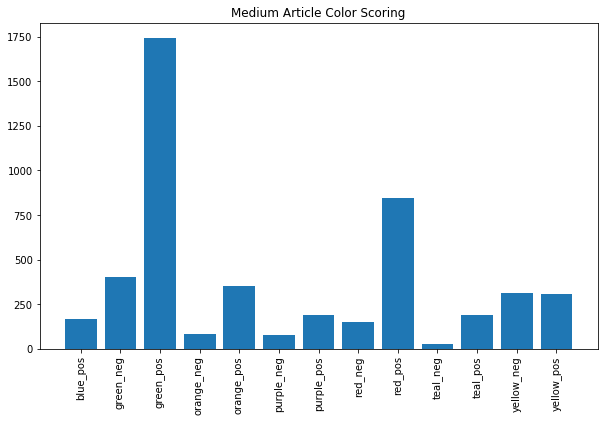

In [6]:
colors = list(data_count.index)[1:]
#['purple', 'blue', 'teal', 'green', 'yellow', 'orange', 'red']
scores = []
for i in range(len(colors)):
    if colors[i] in data_count.index:
        scores.append(data_count.loc[colors[i], 'count'])
    else:
        scores.append(0)
        
plt.bar(colors, scores)
plt.xticks(rotation='vertical')
plt.title('Medium Article Color Scoring')
plt.show()

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()

cv_unigram = CountVectorizer(ngram_range = (1,1), stop_words='english')
cv_bigram = CountVectorizer(ngram_range = (2,2), stop_words='english')

def unigram_themes(data):
    data_cv_stop = cv_unigram.fit_transform(data)
    transformed_weights = transformer.fit_transform(data_cv_stop)
    weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': cv_unigram.get_feature_names(), 'weight': weights})
    return weights_df.sort_values(by='weight', ascending=False).head(7)
    
def bigram_themes(data):
    data_cv_stop = cv_bigram.fit_transform(data)
    transformed_weights = transformer.fit_transform(data_cv_stop)
    weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': cv_bigram.get_feature_names(), 'weight': weights})
    return weights_df.sort_values(by='weight', ascending=False).head(7)

#unigram_themes(clean_corpus)
bigram_themes(list(top_articles['clean_corpus']))

,term,weight
87798,mental health,0.006052
151483,weight loss,0.004506
49153,feel like,0.004221
58289,green tea,0.004025
87806,mental illness,0.003798
38461,don want,0.003624
82442,lose weight,0.003556


In [8]:
data_words = data_df.groupby('color').apply(lambda x: dict(zip(x['word'], x['count']))).reset_index(name='words')
data_words

,color,words
0,blue_neg,"{'aggression': 2, 'aggressive': 3, 'cold': 47,..."
1,blue_pos,"{'faith': 5, 'faithful': 1, 'imagination': 5, ..."
2,green_neg,"{'anxiety': 175, 'anxious': 39, 'envy': 1, 'fe..."
3,green_pos,"{'balance': 52, 'balanced': 18, 'balancing': 5..."
4,orange_neg,"{'ashamed': 14, 'compulsive': 5, 'dependence':..."
5,orange_pos,"{'courage': 9, 'creative': 53, 'creativity': 3..."
6,purple_neg,"{'bore': 1, 'bored': 16, 'boredom': 22, 'confu..."
7,purple_pos,"{'ambition': 2, 'ambitious': 4, 'awake': 19, '..."
8,red_neg,"{'anger': 10, 'angry': 20, 'hopeless': 4, 'hop..."
9,red_pos,"{'desire': 35, 'energy': 184, 'heat': 14, 'hot..."


In [9]:
data = pd.merge(data_count.reset_index(), data_words)
data

,color,count,words
0,blue_neg,90,"{'aggression': 2, 'aggressive': 3, 'cold': 47,..."
1,blue_pos,169,"{'faith': 5, 'faithful': 1, 'imagination': 5, ..."
2,green_neg,401,"{'anxiety': 175, 'anxious': 39, 'envy': 1, 'fe..."
3,green_pos,1742,"{'balance': 52, 'balanced': 18, 'balancing': 5..."
4,orange_neg,82,"{'ashamed': 14, 'compulsive': 5, 'dependence':..."
5,orange_pos,351,"{'courage': 9, 'creative': 53, 'creativity': 3..."
6,purple_neg,79,"{'bore': 1, 'bored': 16, 'boredom': 22, 'confu..."
7,purple_pos,190,"{'ambition': 2, 'ambitious': 4, 'awake': 19, '..."
8,red_neg,151,"{'anger': 10, 'angry': 20, 'hopeless': 4, 'hop..."
9,red_pos,848,"{'desire': 35, 'energy': 184, 'heat': 14, 'hot..."


In [10]:
def append_neighbors_to_df(full_df, top_tags_df):
    
    #dictionary of all related tags
    related_tags = {}
    for dic in top_tags_df['words']:
        related_tags.update(dic)

    for key in related_tags.keys():
        if key not in top_tags_df['color'].values:
            df_entry = full_df[full_df['color'] == key]
            top_tags_df = top_tags_df.append(df_entry)
            
    return top_tags_df

def add_to_graph(graph, top_tags_df ):
    
    for _, tag in top_tags_df.iterrows():

        graph.add_node(tag['color'], size = tag['count']*100)


        combination_of_nodes = [(tag['color'],related_tag) for related_tag in tag['words']]

        for edge in combination_of_nodes:

            if edge in graph.edges:
                pass
            else:
                if edge[1] not in graph.nodes.data() and edge[1] not in top_tags_df['color'].values :
                    graph.add_node(edge[1], size=tag['words'][edge[1]]*100)
                graph.add_edge(*edge)
    return graph
                
    
def visualize_network(dataframe, starting_tags, second_degree=False, third_degree = False, title=None):
    
    top_tags_df = dataframe[dataframe['color'].isin(starting_tags)]
    
    G = nx.Graph()
    sizes = []
    
    if second_degree:
        top_tags_df = append_neighbors_to_df(dataframe, top_tags_df)
        if third_degree:
            top_tags_df = append_neighbors_to_df(dataframe, top_tags_df)

                
    G = add_to_graph(G, top_tags_df)
                
    plt.figure(figsize=[50,50])
    if title:
#         plt.title('Top {0} Tags and their direct neighbors'.format(top_n),fontsize=75)
        plt.title(title)
    
    nx.draw_kamada_kawai(G,
            with_labels=True,
            font_weight='bold',
            font_size=35,
            node_size=[node[1] for node in G.nodes.data('size')],
            weight='frequency')
    return G
def top_n_tags(dataframe, n):
    
    return dataframe.sort_values(by='count', ascending = False).head(n)['color'].values

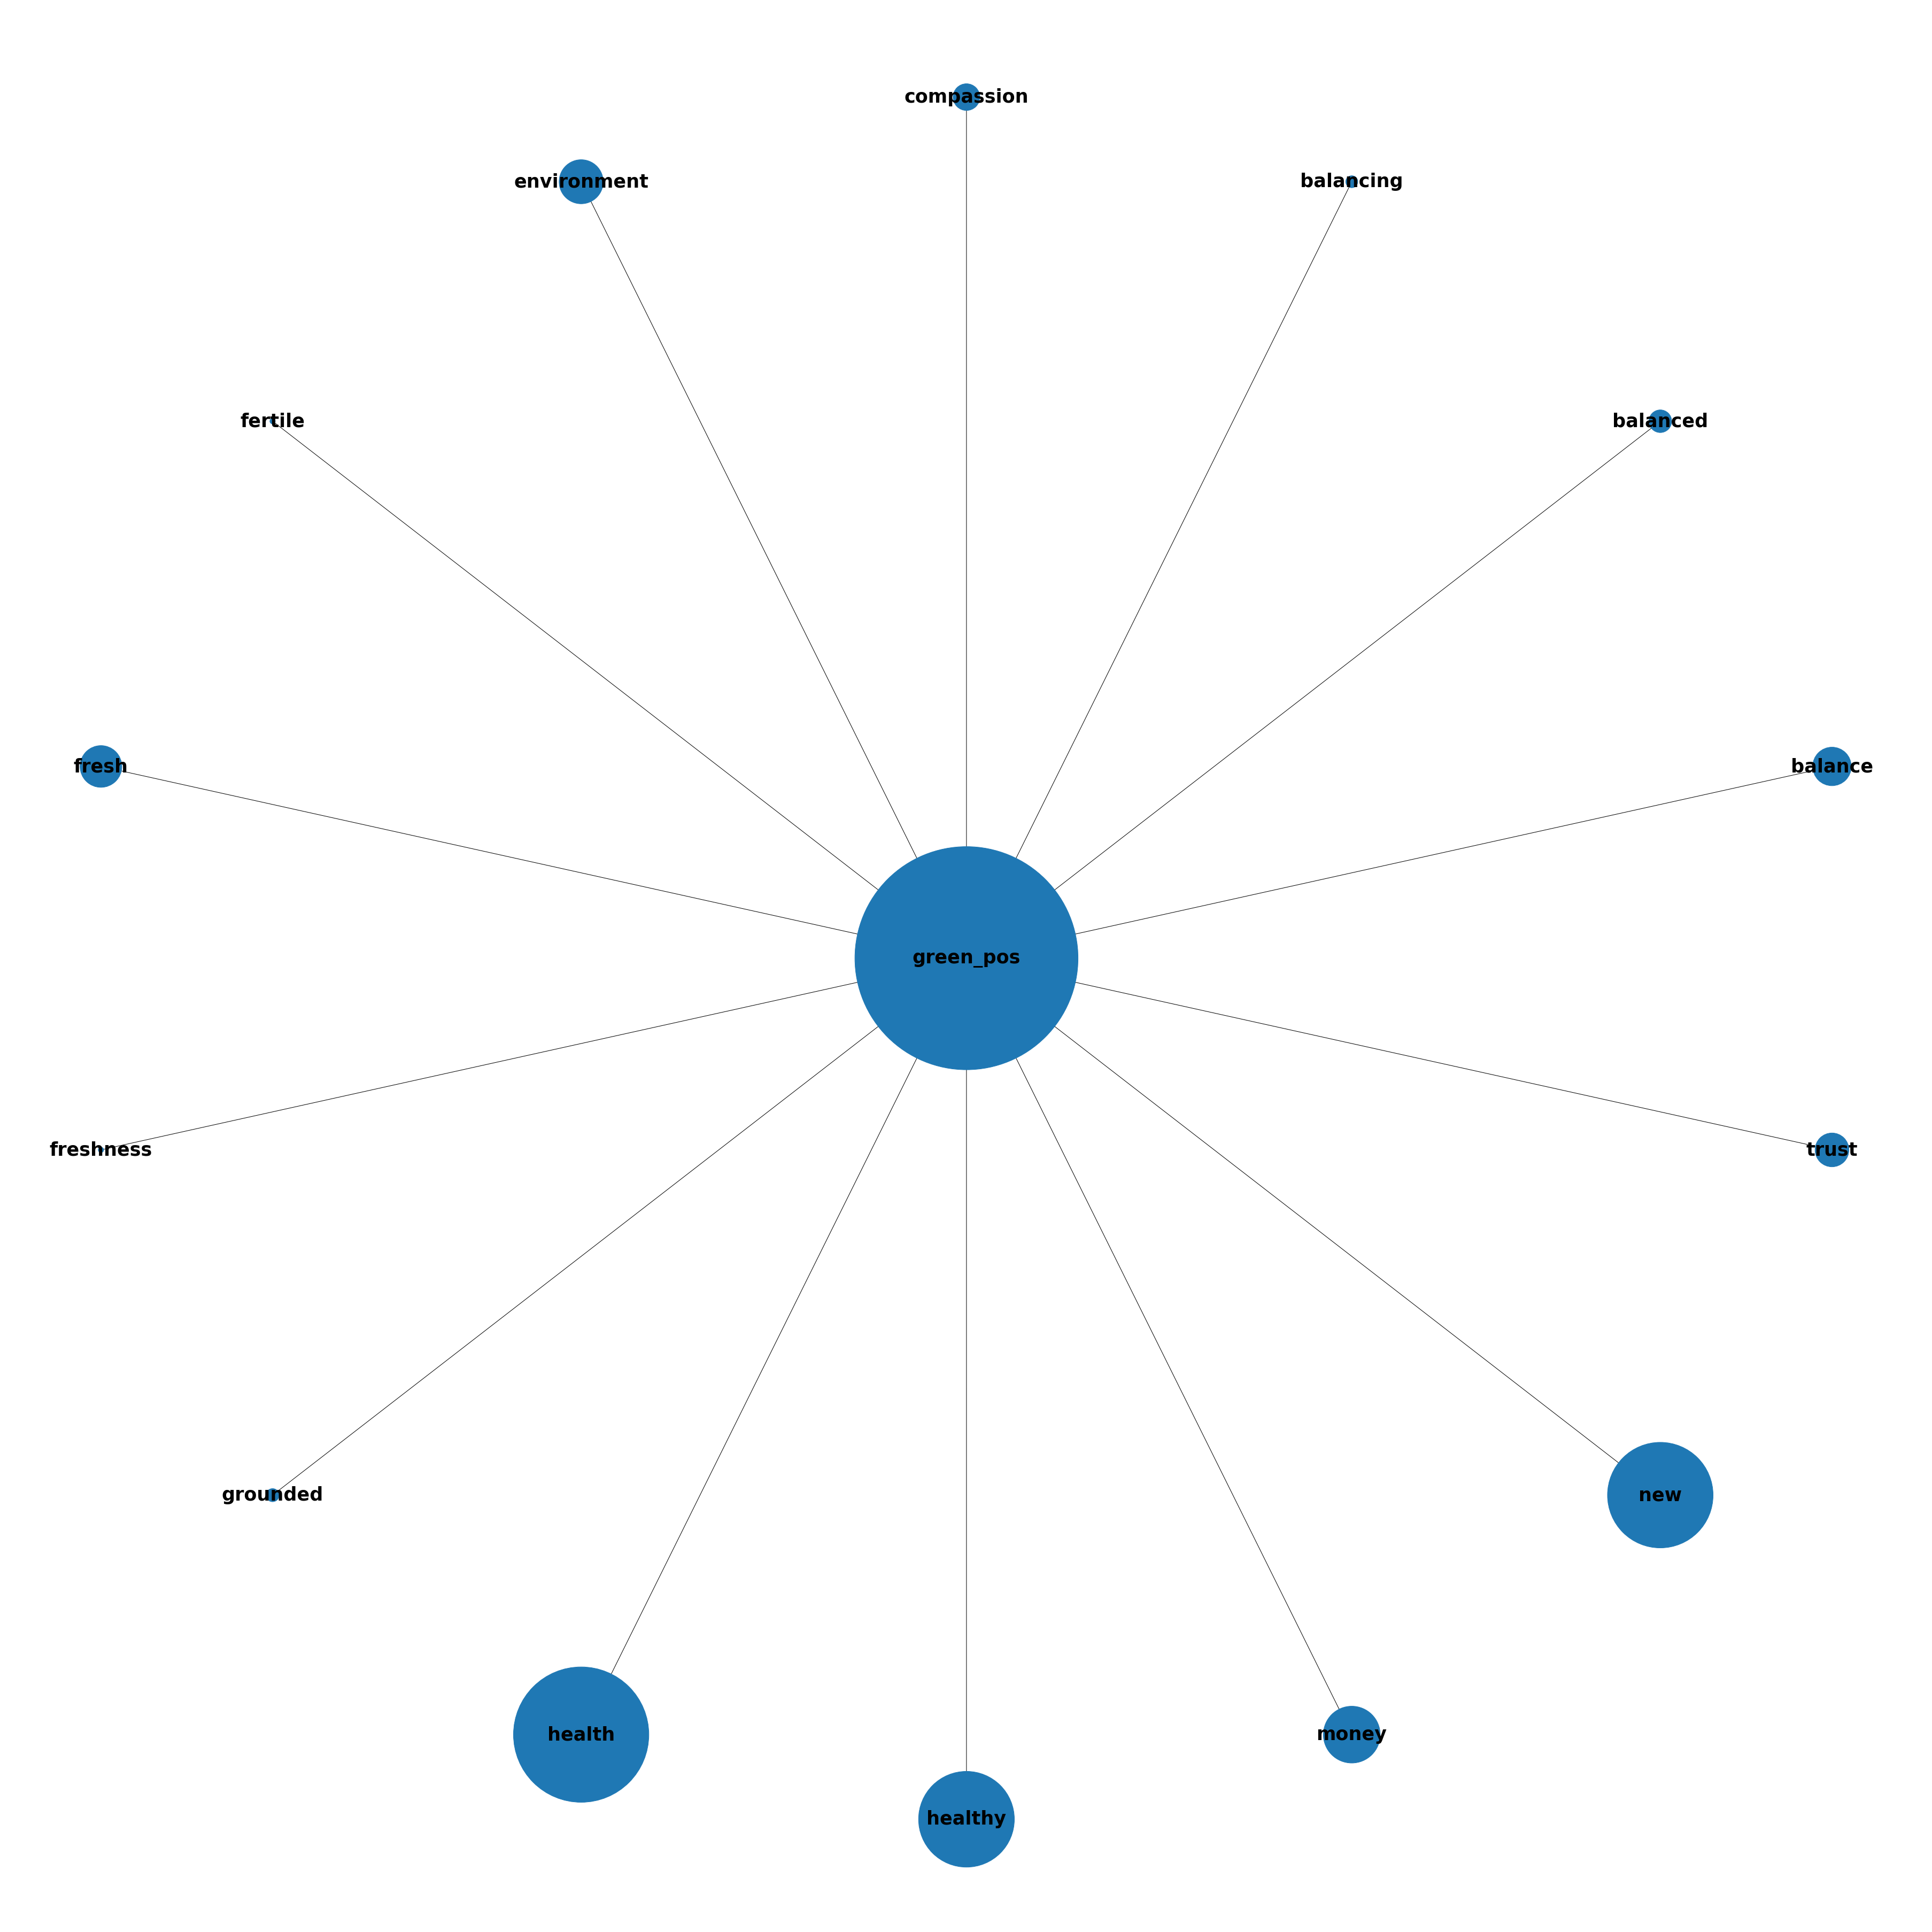

In [11]:
visualize_network(data, ['green_pos'])

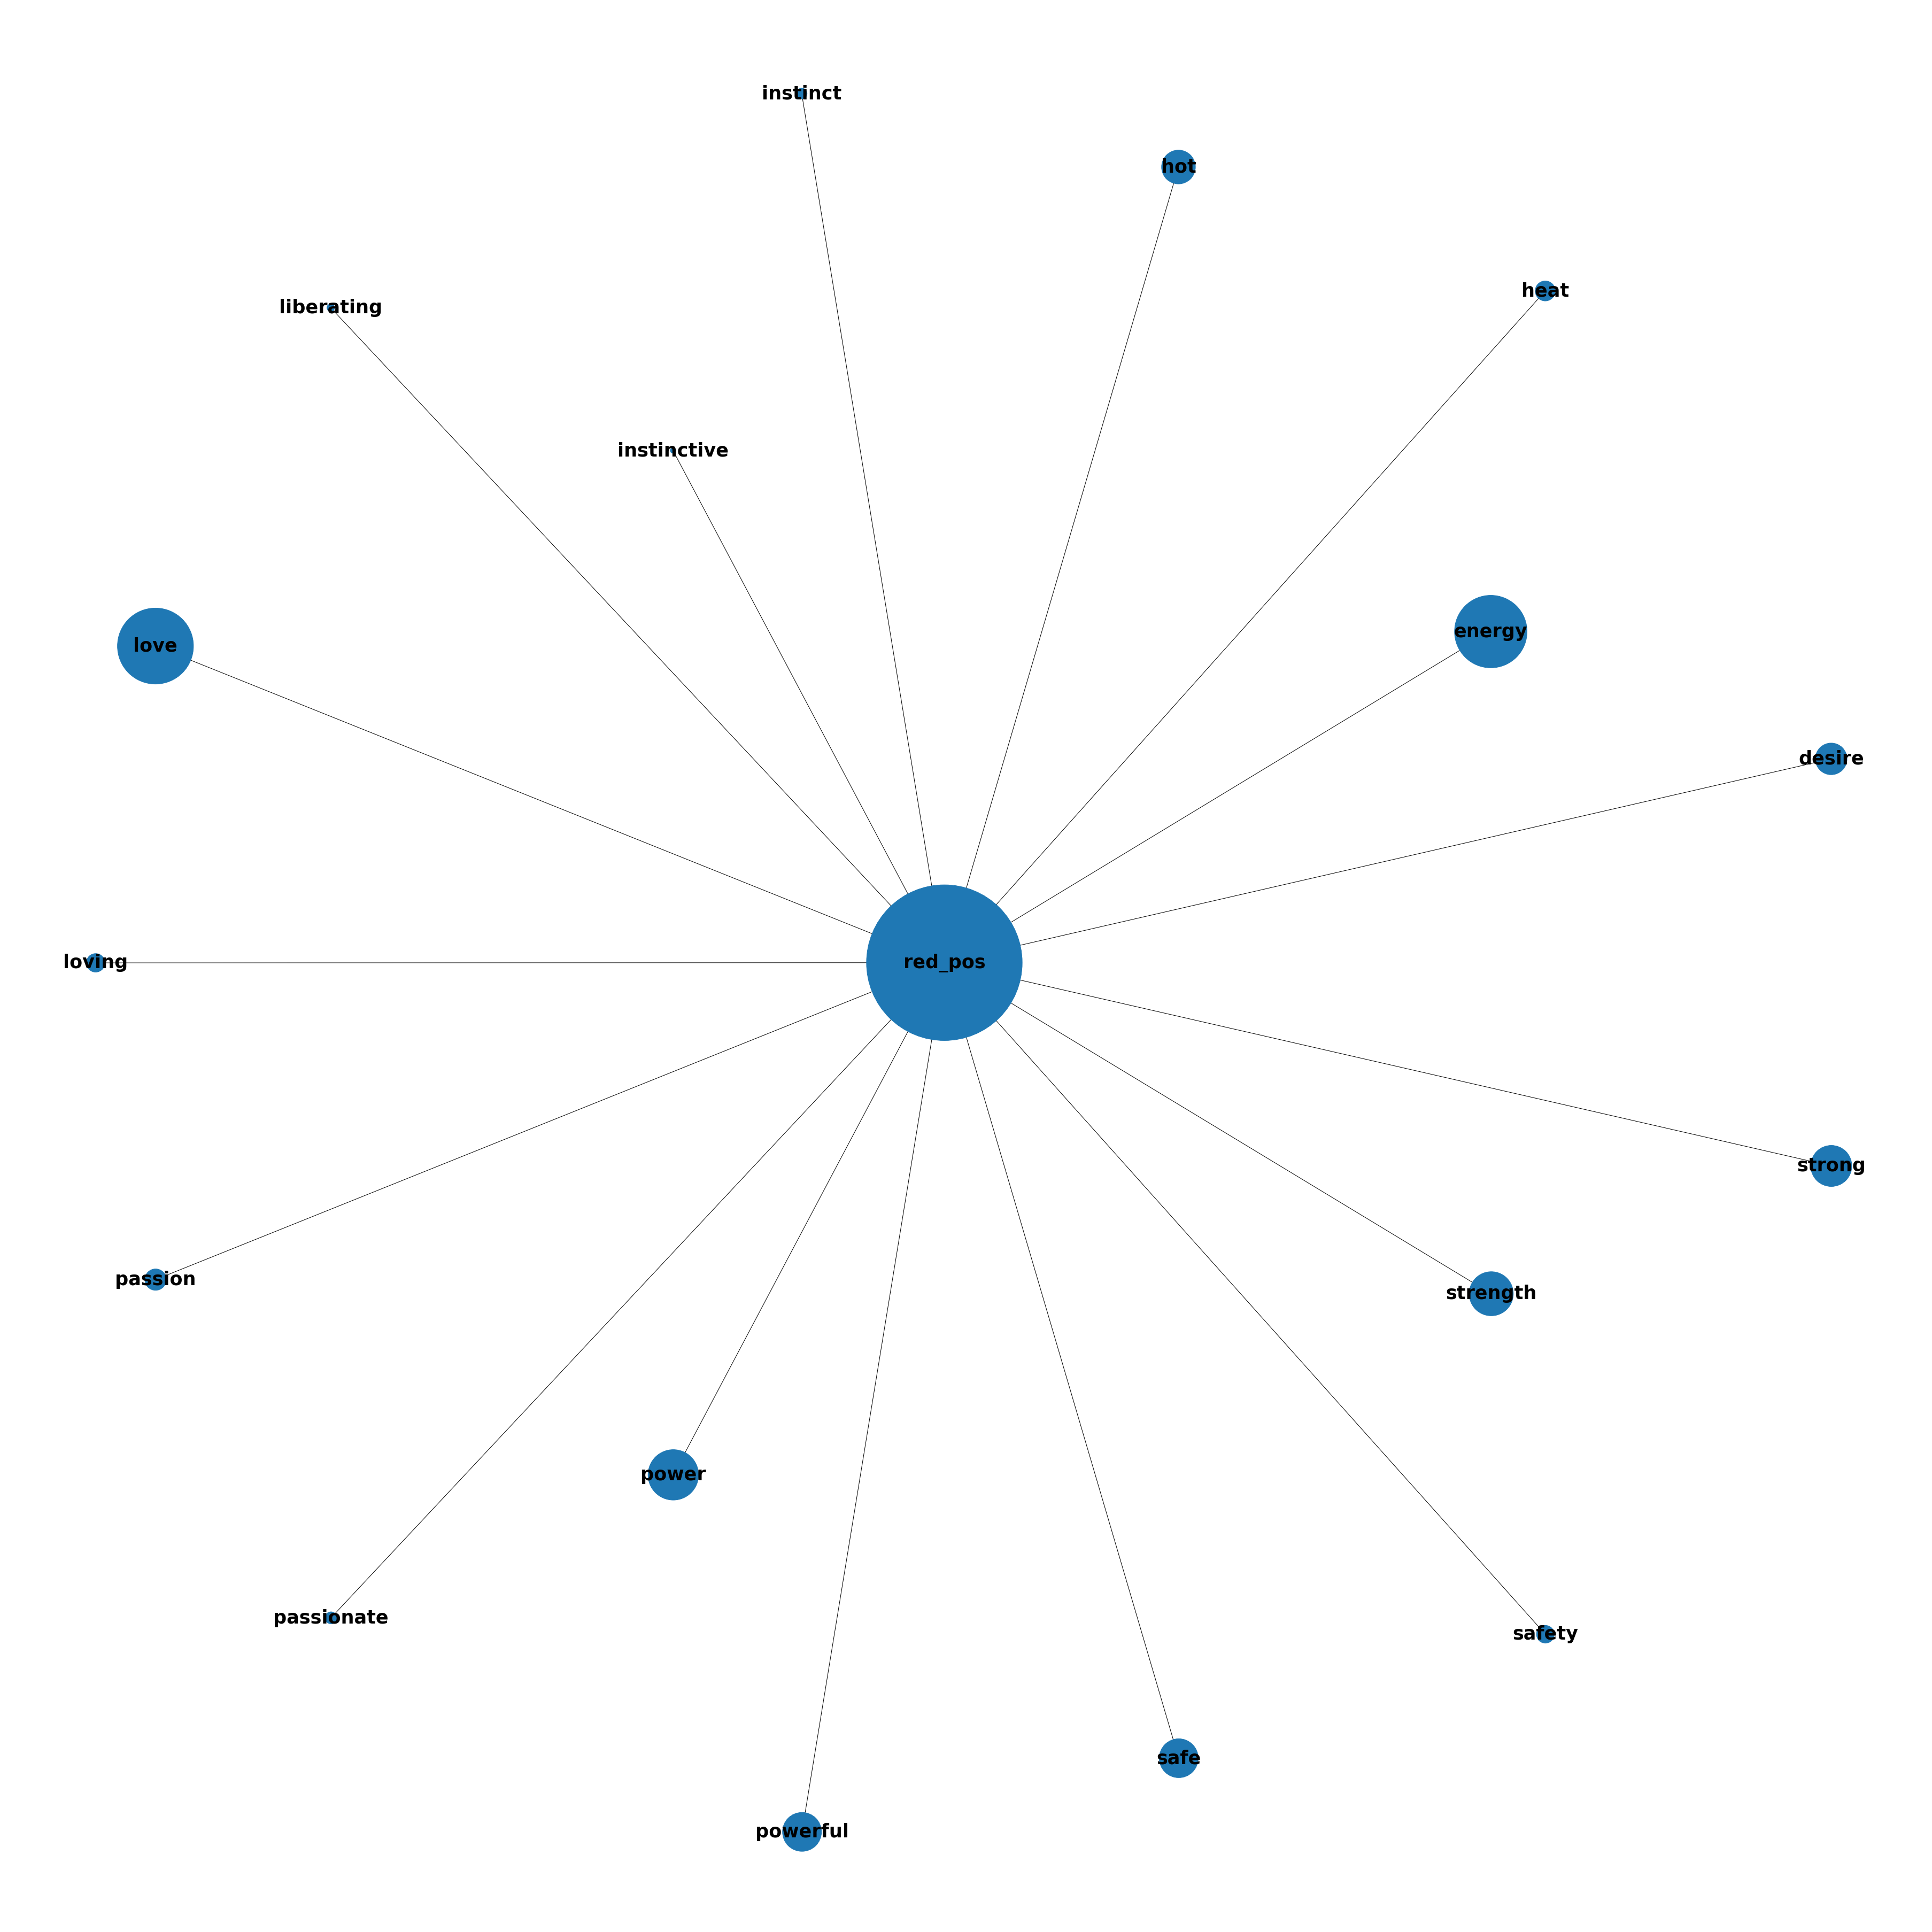

In [12]:
visualize_network(data, ['red_pos'])